#1. Introduction and Background

##Problem Statement
We are a manufactuing company trying to solve a line maintenace problem.  We want to predict when a machine may malfunction based on current sensor readings.  This will ensure maximum "up time".  Additionally, this can prevent actual breakdowns (expensive to fix) and better maintenance (less expensive than fixing), lowering overall operational costs to the company.

## Data Description
We will utlizing 2 sets of data, clean (pre-processed) and dirty (more typical of real world).  Both data sets contain same features and samples as listed below.

### Feature Set
- **Timestamp**: Datetime of sensor reading
- **Machine_ID**: text coantianing id of machine (e.g. M1, M2)
- **Temperature**: float with current temp of machine
- **Vibrations**: float measuring amoutn of machine vibration
- **Pressure**: float measuring the current pressure level of machine

### Target
- **Anomaly**: Boolean indicating machine anomaly</br>
0 = no anamoly present, 1 = anamoly present

#2. EDA
* import required librairies
* set up data import
* load dataframe
* Inspect data via visualization and metrics
* Clean data

## Import Libraries

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_curve, auc, RocCurveDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score,
    matthews_corrcoef, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc, make_scorer)
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, OneClassSVM
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold

## Upload file

In [ ]:
# Open file dialog to upload CSV file
uploaded = files.upload()

Saving production_anomaly_data.csv to production_anomaly_data (1).csv


## Load Dataframe

In [ ]:
#read data anta and display head/info
df_sensors = pd.read_csv(list(uploaded.keys())[0])
df_sensors.head()
df_sensors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Timestamp    1000 non-null   object 
 1   Machine_ID   1000 non-null   object 
 2   Temperature  1000 non-null   float64
 3   Vibration    1000 non-null   float64
 4   Pressure     1000 non-null   float64
 5   Anomaly      1000 non-null   int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 47.0+ KB


In [ ]:
# Step 1: Check for Missing Values
print("Missing values per column:")
print(df_sensors.isnull().sum())

# Step 2: check for Duplicates
print(f"Number of duplicate rows: {df_sensors.duplicated().sum()}")

# Step 3: Detect and Display Outliers (using IQR method)
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.20)
    Q3 = df[column].quantile(0.80)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detect outliers for each numeric column
for column in ['Temperature', 'Vibration', 'Pressure']:
    outliers, lower_bound, upper_bound = detect_outliers(df_sensors, column)
    print(f"\nOutliers in {column} (outside {lower_bound:.2f} to {upper_bound:.2f}):")
    if not outliers.empty:
        print(outliers[['Timestamp', 'Machine_ID', column, 'Anomaly']])
        print(f"Number of outliers: {len(outliers)}")
    else:
        print("No outliers detected.")

Missing values per column:
Timestamp      0
Machine_ID     0
Temperature    0
Vibration      0
Pressure       0
Anomaly        0
dtype: int64
Number of duplicate rows: 0

Outliers in Temperature (outside 58.77 to 91.75):
No outliers detected.

Outliers in Vibration (outside 0.14 to 0.86):
No outliers detected.

Outliers in Pressure (outside 23.22 to 36.87):
               Timestamp Machine_ID   Pressure  Anomaly
430  2023-01-18 22:00:00         M1  22.638657        0
Number of outliers: 1


## Check/update datatypes

In [ ]:
# Display current data types for reference
print("Before data type changes:")
print(df_sensors.dtypes)

# Convert Timestamp from object to datetime64[ns]
df_sensors['Timestamp'] = pd.to_datetime(df_sensors['Timestamp'], errors='coerce')
# Check for any invalid timestamps (converted to NaT)
invalid_timestamps = df_sensors['Timestamp'].isna().sum()
if invalid_timestamps > 0:
    print(f"Warning: {invalid_timestamps} invalid timestamps converted to NaT.")

# Verify other columns (no changes needed, just confirming)
df_sensors['Machine_ID'] = df_sensors['Machine_ID'].astype(str)  # Ensure object is treated as string
df_sensors['Temperature'] = df_sensors['Temperature'].astype(float)  # Already float64, just explicit
df_sensors['Vibration'] = df_sensors['Vibration'].astype(float)      # Already float64, just explicit
df_sensors['Pressure'] = df_sensors['Pressure'].astype(float)        # Already float64, just explicit

# Display updated data types
print("\nAfter data type changes:")
print(df_sensors.dtypes)

# Preview the first few rows to confirm changes
print("\nFirst 5 rows of updated DataFrame:")
print(df_sensors.head())

Before data type changes:
Timestamp       object
Machine_ID      object
Temperature    float64
Vibration      float64
Pressure       float64
Anomaly          int64
dtype: object

After data type changes:
Timestamp      datetime64[ns]
Machine_ID             object
Temperature           float64
Vibration             float64
Pressure              float64
Anomaly                 int64
dtype: object

First 5 rows of updated DataFrame:
            Timestamp Machine_ID  Temperature  Vibration   Pressure  Anomaly
0 2023-01-01 00:00:00         M1    69.314313   0.368329  30.381583        0
1 2023-01-01 01:00:00         M3    75.209307   0.732900  25.867725        0
2 2023-01-01 02:00:00         M1    79.237698   0.559727  30.548358        0
3 2023-01-01 03:00:00         M2    68.092564   0.359639  31.655909        0
4 2023-01-01 04:00:00         M2    70.349311   0.557938  31.938784        0


## Check for inconsistent Machine_ID and non boolean Anamoly

In [ ]:
# Check Machine_ID consistency
valid_machines = {'M1', 'M2', 'M3', 'M4'}  # Set of expected Machine_IDs
unique_machines = set(df_sensors['Machine_ID'].unique())
print("Unique Machine_IDs found:", unique_machines)

# Check if there are any unexpected Machine_IDs
invalid_machines = unique_machines - valid_machines
if invalid_machines:
    print(f"Warning: Invalid Machine_IDs detected: {invalid_machines}")
    # Filter out rows with invalid Machine_IDs
    df_sensors = df_sensors[df_sensors['Machine_ID'].isin(valid_machines)]
    print(f"Removed {len(unique_machines) - len(valid_machines)} invalid Machine_IDs.")
else:
    print("All Machine_IDs are valid.")

# Check Anomaly consistency (should be True/False since it's bool)
unique_anomalies = df_sensors['Anomaly'].unique()
print("Unique Anomaly values found:", unique_anomalies)

# Since Anomaly is bool, it should only be True/False, but let's confirm
if set(unique_anomalies) != {True, False}:
    print("Warning: Anomaly contains unexpected values!")
    # Filter to only True/False (shouldn't be needed with bool type, but safety check)
    df_sensors = df_sensors[df_sensors['Anomaly'].isin([True, False])]
    print("Filtered Anomaly to only True/False.")
else:
    print("Anomaly values are consistent (True/False only).")

# Display basic stats to confirm consistency
print("\nMachine_ID value counts:")
print(df_sensors['Machine_ID'].value_counts())
print("\nAnomaly value counts:")
print(df_sensors['Anomaly'].value_counts())

# Preview the DataFrame after consistency checks
print("\nFirst 5 rows of DataFrame after Step 5:")
print(df_sensors.head())

Unique Machine_IDs found: {'M3', 'M4', 'M2', 'M1'}
All Machine_IDs are valid.
Unique Anomaly values found: [0 1]
Anomaly values are consistent (True/False only).

Machine_ID value counts:
Machine_ID
M2    264
M1    247
M4    247
M3    242
Name: count, dtype: int64

Anomaly value counts:
Anomaly
0    957
1     43
Name: count, dtype: int64

First 5 rows of DataFrame after Step 5:
            Timestamp Machine_ID  Temperature  Vibration   Pressure  Anomaly
0 2023-01-01 00:00:00         M1    69.314313   0.368329  30.381583        0
1 2023-01-01 01:00:00         M3    75.209307   0.732900  25.867725        0
2 2023-01-01 02:00:00         M1    79.237698   0.559727  30.548358        0
3 2023-01-01 03:00:00         M2    68.092564   0.359639  31.655909        0
4 2023-01-01 04:00:00         M2    70.349311   0.557938  31.938784        0


## Sort by timestamp to ensure chronological order

In [ ]:
df_sensors = df_sensors.sort_values('Timestamp')

# Confirm sorting
print("First 5 rows after sorting by Timestamp:")
print(df_sensors.head())
print("\nLast 5 rows after sorting by Timestamp:")
print(df_sensors.tail())

First 5 rows after sorting by Timestamp:
            Timestamp Machine_ID  Temperature  Vibration   Pressure  Anomaly
0 2023-01-01 00:00:00         M1    69.314313   0.368329  30.381583        0
1 2023-01-01 01:00:00         M3    75.209307   0.732900  25.867725        0
2 2023-01-01 02:00:00         M1    79.237698   0.559727  30.548358        0
3 2023-01-01 03:00:00         M2    68.092564   0.359639  31.655909        0
4 2023-01-01 04:00:00         M2    70.349311   0.557938  31.938784        0

Last 5 rows after sorting by Timestamp:
              Timestamp Machine_ID  Temperature  Vibration   Pressure  Anomaly
995 2023-02-11 11:00:00         M3    79.179948   0.574841  31.098900        0
996 2023-02-11 12:00:00         M2    70.153030   0.448646  28.971109        0
997 2023-02-11 13:00:00         M2    79.498489   0.444485  30.652240        0
998 2023-02-11 14:00:00         M1    78.215578   0.443462  30.484907        0
999 2023-02-11 15:00:00         M4    81.126049   0.256239  3

## Time Series plot - Sensor readings with anamolies

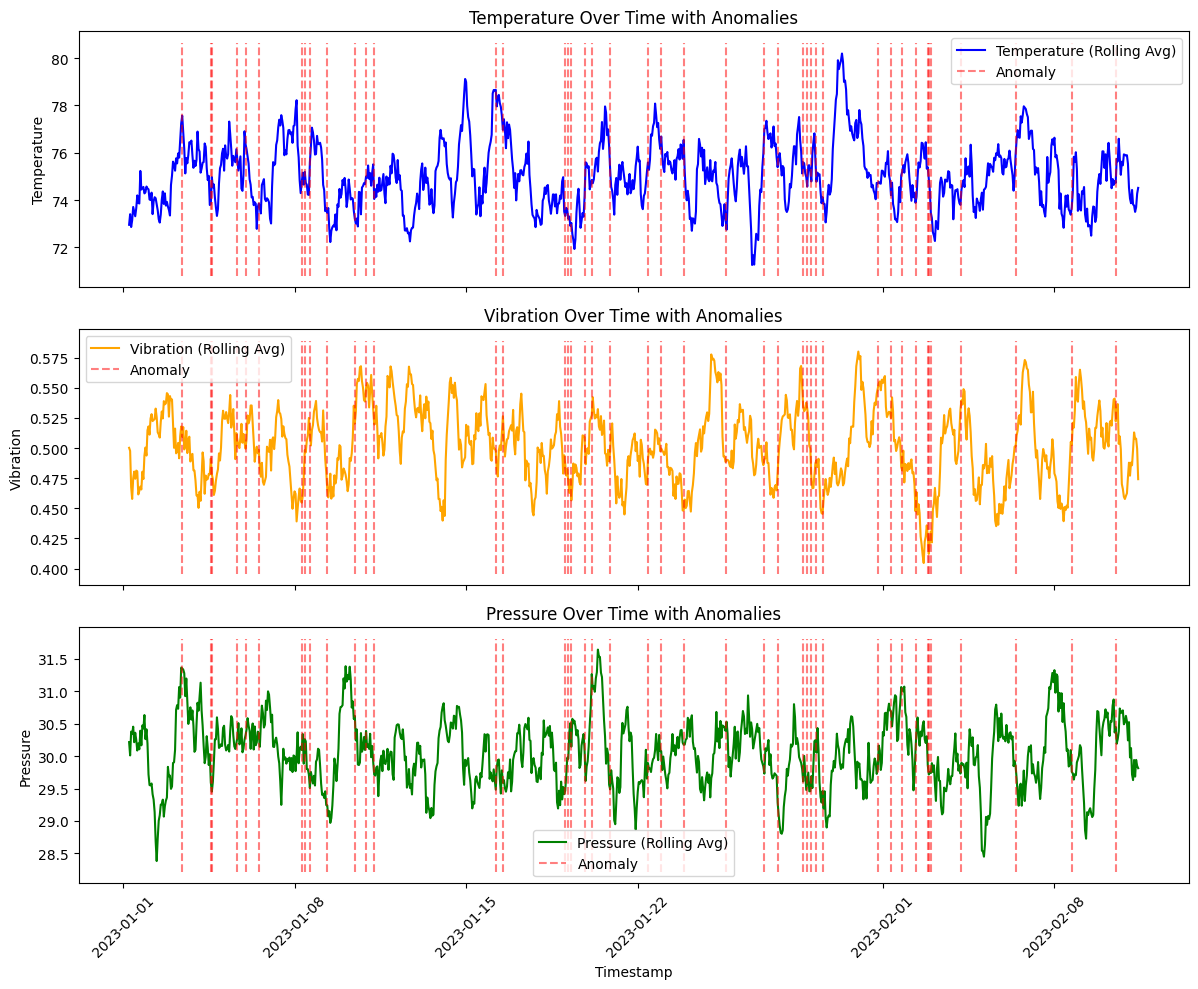

In [ ]:
# Apply a 12-hour rolling average to smooth the data
window = 12
df_sensors['Temp_Rolling'] = df_sensors['Temperature'].rolling(window=window, center=True).mean()
df_sensors['Vib_Rolling'] = df_sensors['Vibration'].rolling(window=window, center=True).mean()
df_sensors['Press_Rolling'] = df_sensors['Pressure'].rolling(window=window, center=True).mean()

# Plot each sensor in a subplot
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Temperature
axes[0].plot(df_sensors['Timestamp'], df_sensors['Temp_Rolling'], label='Temperature (Rolling Avg)', color='blue')
axes[0].set_ylabel('Temperature')
axes[0].set_title('Temperature Over Time with Anomalies')
axes[0].legend()

# Vibration
axes[1].plot(df_sensors['Timestamp'], df_sensors['Vib_Rolling'], label='Vibration (Rolling Avg)', color='orange')
axes[1].set_ylabel('Vibration')
axes[1].set_title('Vibration Over Time with Anomalies')
axes[1].legend()

# Pressure
axes[2].plot(df_sensors['Timestamp'], df_sensors['Press_Rolling'], label='Pressure (Rolling Avg)', color='green')
axes[2].set_ylabel('Pressure')
axes[2].set_title('Pressure Over Time with Anomalies')
axes[2].legend()

# Add anomaly markers to all subplots
# Changed to index using boolean filtering
anomaly_times = df_sensors[df_sensors['Anomaly'] == True]['Timestamp']
for ax in axes:
    ax.vlines(anomaly_times, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='red', linestyle='--', label='Anomaly', alpha=0.5)
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

plt.xlabel('Timestamp')
plt.tight_layout()
plt.show()

no obvious trends across machines or within a specific machine

## Facet by Machine

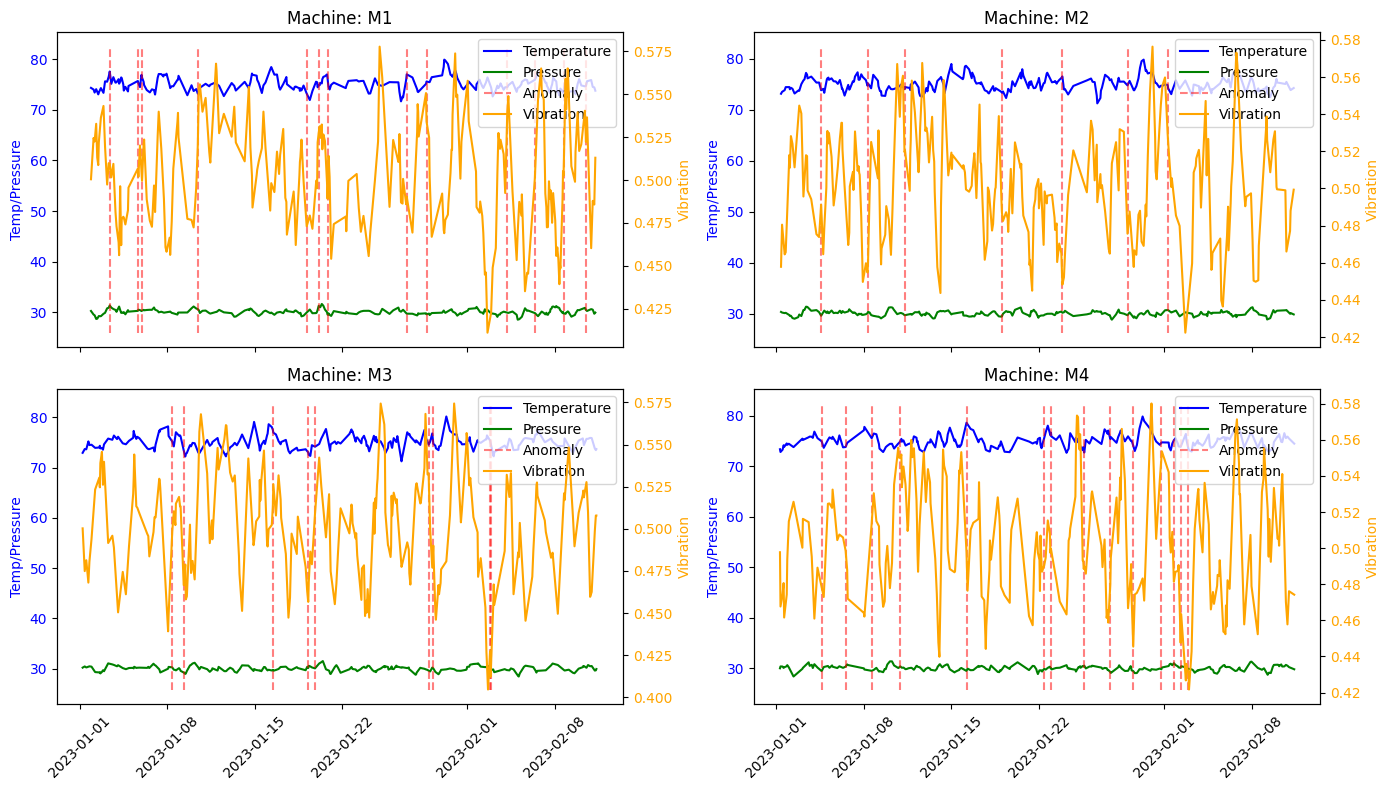

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
axes = axes.flatten()

for i, machine in enumerate(['M1', 'M2', 'M3', 'M4']):
    ax = axes[i]
    machine_data = df_sensors[df_sensors['Machine_ID'] == machine]

    # Plot Temperature and Pressure on the left y-axis
    ax.plot(machine_data['Timestamp'], machine_data['Temp_Rolling'], label='Temperature', color='blue')
    ax.plot(machine_data['Timestamp'], machine_data['Press_Rolling'], label='Pressure', color='green')
    ax.set_ylabel('Temp/Pressure', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')

    # Create a second y-axis for Vibration
    ax2 = ax.twinx()
    ax2.plot(machine_data['Timestamp'], machine_data['Vib_Rolling'], label='Vibration', color='orange')
    ax2.set_ylabel('Vibration', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Add anomaly markers
    anomaly_times = machine_data[machine_data['Anomaly'] == True]['Timestamp'] # Correct
    ax.vlines(anomaly_times, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='red', linestyle='--', label='Anomaly', alpha=0.5)

    ax.set_title(f'Machine: {machine}')
    ax.tick_params(axis='x', rotation=45)

    # Combine legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.xlabel('Timestamp')
plt.tight_layout()
plt.show()

Again, no obvious trends

## Temp vs Vibration

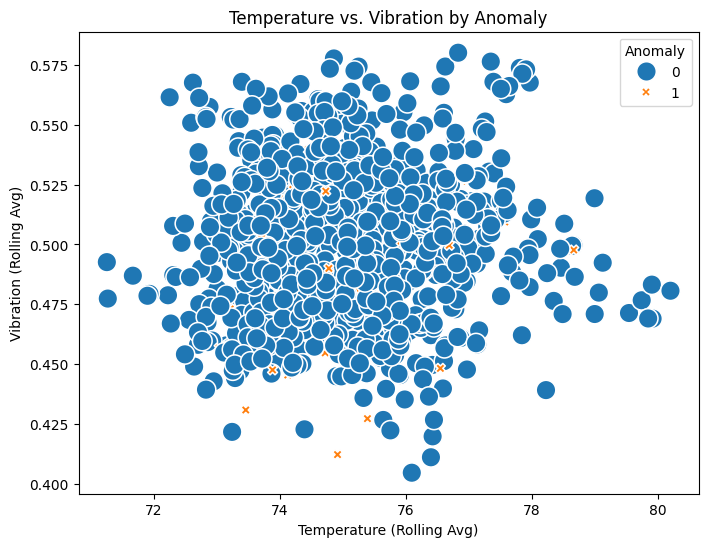

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_sensors, x='Temp_Rolling', y='Vib_Rolling', hue='Anomaly', style='Anomaly', size='Anomaly', sizes=(50, 200))
plt.xlabel('Temperature (Rolling Avg)')
plt.ylabel('Vibration (Rolling Avg)')
plt.title('Temperature vs. Vibration by Anomaly')
plt.show()

There is not a strong correlation.

## Temp vs Pressure

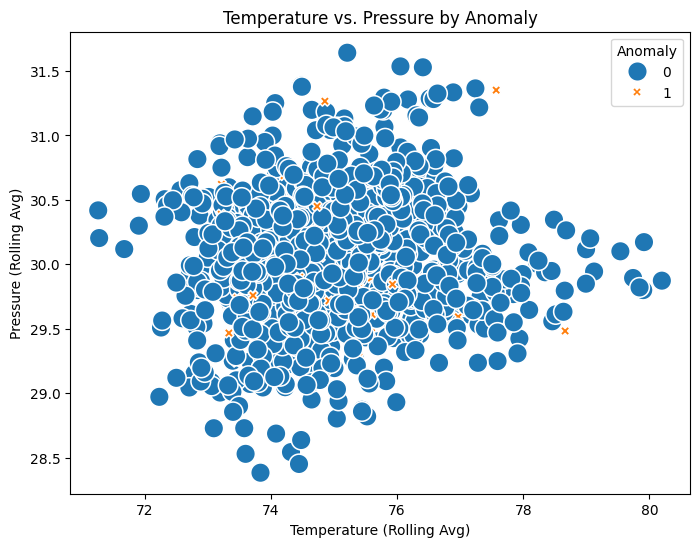

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_sensors, x='Temp_Rolling', y='Press_Rolling', hue='Anomaly', style='Anomaly', size='Anomaly', sizes=(50, 200))
plt.xlabel('Temperature (Rolling Avg)')
plt.ylabel('Pressure (Rolling Avg)')
plt.title('Temperature vs. Pressure by Anomaly')
plt.show()

There is not a strong correlation

## Vibration vs Pressure

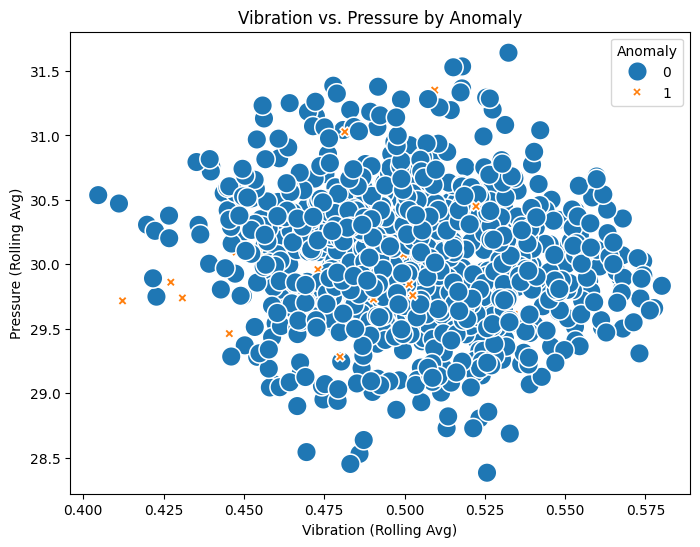

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_sensors, x='Vib_Rolling', y='Press_Rolling', hue='Anomaly', style='Anomaly', size='Anomaly', sizes=(50, 200))
plt.xlabel('Vibration (Rolling Avg)')
plt.ylabel('Pressure (Rolling Avg)')
plt.title('Vibration vs. Pressure by Anomaly')
plt.show()

there looks like a small (weak) correaltion between Anomaly and below average pressure/vibration combo.  However, not enough examples for statistical significance

## Feature Engineering
With high data bias we and widely distributed Anomaly occurences we will attempt to engineer lag features to determine these anomalies share a similar lag experience.

Lagged values for 1/2 hours prior

In [ ]:
# add lag for each sensor
for col in ['Temperature', 'Vibration', 'Pressure']:
    df_sensors[f'{col}_lag1'] = df_sensors[col].shift(1)
    df_sensors[f'{col}_lag2'] = df_sensors[col].shift(2)

Rollling mean and std for past 5 hours

In [ ]:
# add rolling stats
for col in ['Temperature', 'Vibration', 'Pressure']:
    df_sensors[f'{col}_roll_mean_5'] = df_sensors[col].rolling(window=5).mean()
    df_sensors[f'{col}_roll_std_5'] = df_sensors[col].rolling(window=5).std()

hour over hour change

In [ ]:
# add change over time (delta)
for col in ['Temperature', 'Vibration', 'Pressure']:
    df_sensors[f'{col}_delta'] = df_sensors[col] - df_sensors[col].shift(1)

In [ ]:
#drop NA values introduced by lag/roll
df_sensors.dropna(inplace=True)

### Correlation Matrix for verification of features

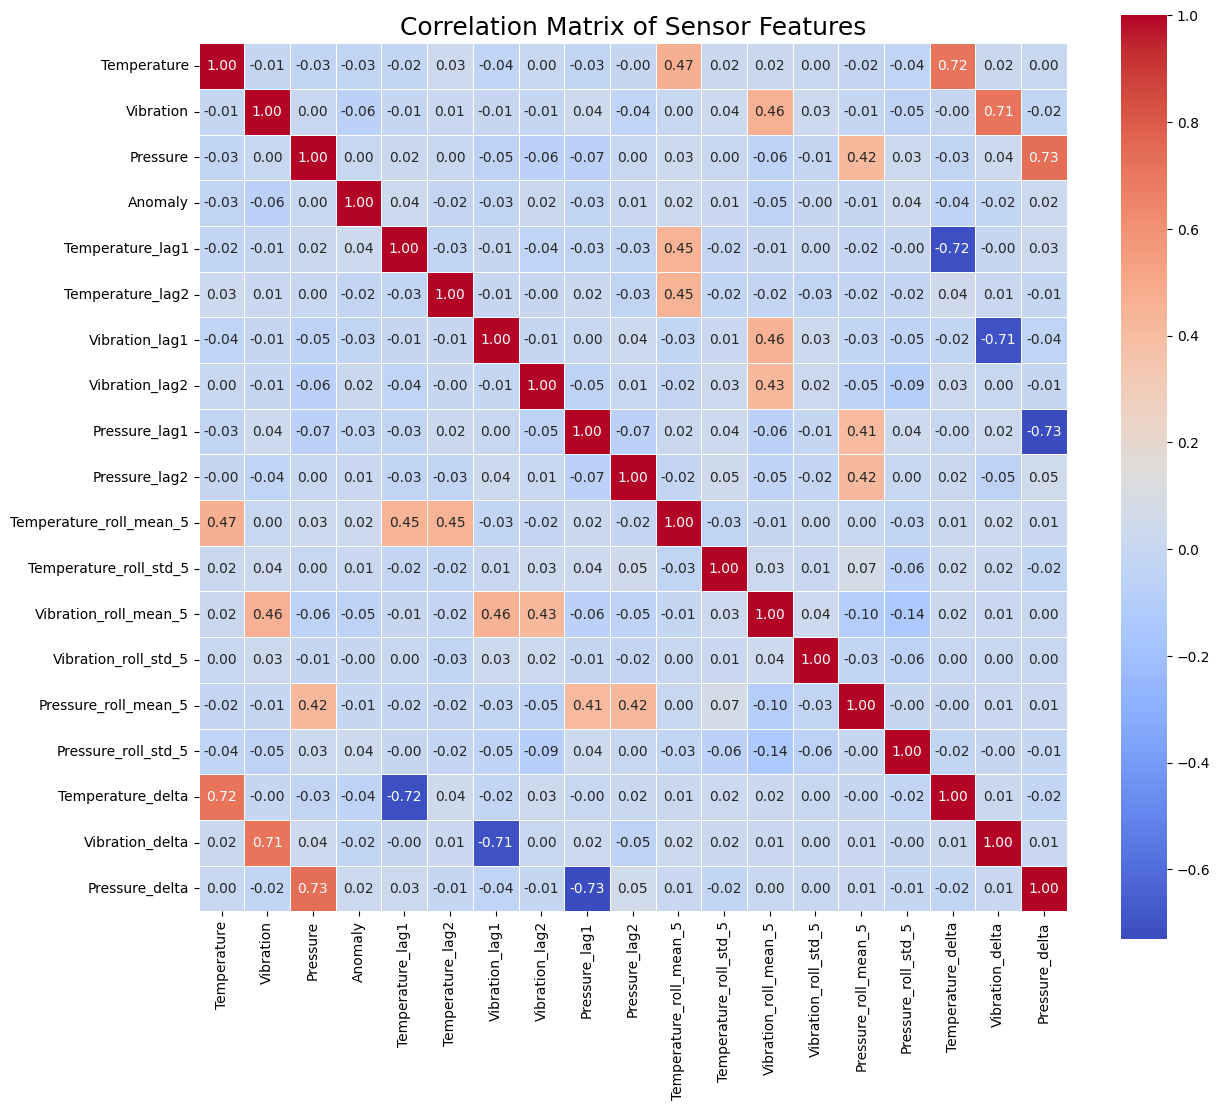

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop non-numeric columns
df_corr = df_sensors.drop(columns=['Timestamp', 'Machine_ID'])

# Compute correlation matrix
corr = df_corr.corr()

# Set up the matplotlib figure
plt.figure(figsize=(14, 12))

# Draw the heatmap
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", square=True, linewidths=0.5)

plt.title('Correlation Matrix of Sensor Features', fontsize=18)
plt.show()


There is a correlation between _deltas and lag_1 (negative) and _delta and original (positive).  we test both with and wothout _deltas

# Model Selection

The data bias poses some issues with modelling.  We have a 95%+ uptime rate (Anomaly=0) which makes sense for this data set but also puts in a postion where creating a predictive model with higher accuracy may not be possible. We will try a Random Forest and maybe an Autoencoder (RNN) if needed

## Pre-processing
Set features, Standardize data, extract features and labels  

### Train/Test and feature selection

In [ ]:
from sklearn.model_selection import train_test_split

# Drop non-feature columns
X = df_sensors.drop(columns=['Timestamp', 'Machine_ID', 'Anomaly'])
y = df_sensors['Anomaly'].astype(int)

# Stratified split to preserve class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Random Forest


Evaluation Metrics:
              precision    recall  f1-score   support

      Normal       0.95      1.00      0.98       188
     Anomaly       0.00      0.00      0.00         9

    accuracy                           0.95       197
   macro avg       0.48      0.50      0.49       197
weighted avg       0.91      0.95      0.93       197


Final predictions saved to 'df_sensors_with_rf_predictions.csv'!


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


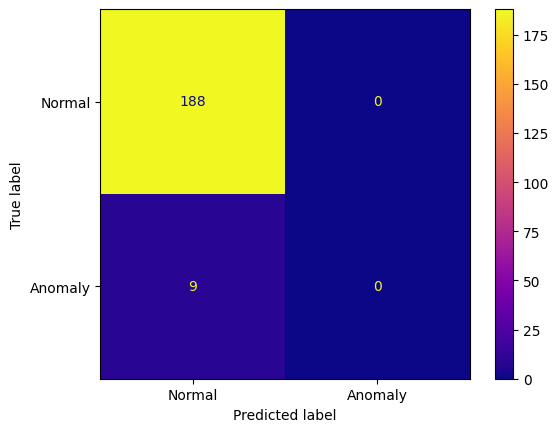

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- 1. Prepare Dataset ---

# Shift anomaly labels UP by 5 (look ahead 5 hours)
df_sensors['Future_Anomaly'] = df_sensors['Anomaly'].shift(-5)

# Drop any rows with NaN created by shift
df_sensors = df_sensors.dropna()

# Drop non-feature columns
X = df_sensors.drop(columns=['Timestamp', 'Machine_ID', 'Anomaly', 'Future_Anomaly'])
y = df_sensors['Future_Anomaly'].astype(int)

# --- 2. Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 3. Train Random Forest Model ---
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',  # handle heavy imbalance
    random_state=42
)

rf_model.fit(X_train, y_train)

# --- 4. Predict and Evaluate ---
y_pred = rf_model.predict(X_test)

print("\nEvaluation Metrics:")
print(classification_report(y_test, y_pred, target_names=["Normal", "Anomaly"]))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap="plasma")

# --- 5. Predict on the FULL dataset for dashboard ---

# Predict on all rows (excluding training/test split)
full_predictions = rf_model.predict(X)

# Add predictions to df_sensors
df_sensors['Predicted_Maintenance_Status'] = np.where(full_predictions == 1, "Needs Attention", "Normal")

# --- 6. Save to CSV for Streamlit ---
df_sensors_to_save = df_sensors[['Timestamp', 'Machine_ID', 'Temperature', 'Vibration', 'Pressure', 'Predicted_Maintenance_Status']]
df_sensors_to_save.to_csv("df_sensors_with_rf_predictions.csv", index=False)

print("\nFinal predictions saved to 'df_sensors_with_rf_predictions.csv'!")


### undersample

In [ ]:
# Combine X and y
X['Future_Anomaly'] = y

# Split Normal and Anomaly
normal = X[X['Future_Anomaly'] == 0]
anomaly = X[X['Future_Anomaly'] == 1]

# Undersample Normal
normal_downsampled = normal.sample(n=len(anomaly)*3, random_state=42)  # 3x more normals than anomalies

# Combine undersampled normal + anomalies
undersampled = pd.concat([normal_downsampled, anomaly])

# Separate features and labels again
X_balanced = undersampled.drop(columns=['Future_Anomaly'])
y_balanced = undersampled['Future_Anomaly']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# Train Random Forest again
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)


Evaluation Metrics (Undersampled Training):
              precision    recall  f1-score   support

      Normal       0.74      1.00      0.85        26
     Anomaly       0.00      0.00      0.00         9

    accuracy                           0.74        35
   macro avg       0.37      0.50      0.43        35
weighted avg       0.55      0.74      0.63        35



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


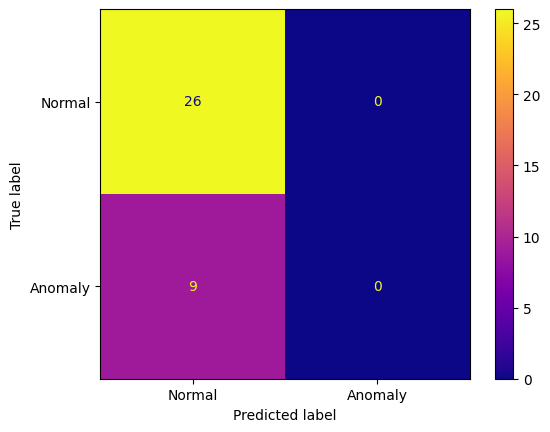

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Predict on test set ---
y_pred = rf_model.predict(X_test)

# --- Print evaluation metrics ---
print("\nEvaluation Metrics (Undersampled Training):")
print(classification_report(y_test, y_pred, target_names=["Normal", "Anomaly"]))

# --- Plot confusion matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap="plasma")


Random Forest/Isolation Forest will not work</br>
THey are unable to catch sequence oriented failures

## LSTM Bidirectional Autoencoder (RNN)


### Prep
* Drop columns
* Split data (LSTM is trained ONLY on "normal" data, no anomalies)
* Scale data
* Sequence data
* Show shape
* Compile/Fit model

In [ ]:
# --- DROP everything non-numeric FIRST ---
columns_to_drop = [
    'Timestamp',
    'Machine_ID',
    'Anomaly',
    'Future_Anomaly',
    'Predicted_Maintenance_Status',
    'Maintenance_Status',
    'Maintenance_Status_4hr'
]

# Drop columns safely
df_clean = df_sensors.drop(columns=columns_to_drop, errors='ignore')

# --- NOW split into normal and anomalous ---
df_normal = df_clean[df_sensors['Anomaly'] == 0]
df_anomalous = df_clean[df_sensors['Anomaly'] == 1]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split normal data
df_normal_train, df_normal_temp = train_test_split(df_normal, test_size=0.2, random_state=42)
df_normal_val, df_normal_test = train_test_split(df_normal_temp, test_size=0.5, random_state=42)


In [ ]:
scaler = StandardScaler()
X_train_normal_scaled = scaler.fit_transform(df_normal_train)
X_val_normal_scaled = scaler.transform(df_normal_val)
X_test_normal_scaled = scaler.transform(df_normal_test)
X_test_anomalous_scaled = scaler.transform(df_anomalous)


In [ ]:
SEQ_LEN = 7

def create_sequences(data, labels, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(labels[i+seq_length])
    return np.array(X), np.array(y)

# Create sequences
X_train_seq, _ = create_sequences(X_train_normal_scaled, np.zeros(len(X_train_normal_scaled)), SEQ_LEN)
X_val_seq, _ = create_sequences(X_val_normal_scaled, np.zeros(len(X_val_normal_scaled)), SEQ_LEN)

X_test_normal_seq, y_test_normal_seq = create_sequences(X_test_normal_scaled, np.zeros(len(X_test_normal_scaled)), SEQ_LEN)
X_test_anomalous_seq, y_test_anomalous_seq = create_sequences(X_test_anomalous_scaled, np.ones(len(X_test_anomalous_scaled)), SEQ_LEN)

# Combine test sets
X_test_seq = np.concatenate([X_test_normal_seq, X_test_anomalous_seq])
y_test_seq = np.concatenate([y_test_normal_seq, y_test_anomalous_seq])


In [ ]:
timesteps = X_train_seq.shape[1]
n_features = X_train_seq.shape[2]

print(f"Shape of X_train_seq: {X_train_seq.shape}")
print(f"Shape of X_val_seq: {X_val_seq.shape}")
print(f"Shape of X_test_seq: {X_test_seq.shape}")
print(f"Shape of y_test_seq: {y_test_seq.shape}")
print(f"Timesteps: {timesteps}")
print(f"Number of features: {n_features}")
print(f"Number of anomalies in y_test_seq: {np.sum(y_test_seq)}")


Shape of X_train_seq: (755, 7, 18)
Shape of X_val_seq: (88, 7, 18)
Shape of X_test_seq: (125, 7, 18)
Shape of y_test_seq: (125,)
Timesteps: 7
Number of features: 18
Number of anomalies in y_test_seq: 36.0


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Model
model = Sequential([
    Bidirectional(LSTM(64, activation='relu'), input_shape=(timesteps, n_features)),
    RepeatVector(timesteps),
    Bidirectional(LSTM(64, activation='relu', return_sequences=True)),
    TimeDistributed(Dense(n_features))
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Fit
history = model.fit(
    X_train_seq, X_train_seq,
    epochs=75,
    batch_size=32,
    validation_data=(X_val_seq, X_val_seq),
    verbose=1,
    shuffle=False,
    callbacks=[early_stopping]
)

# Save
model.save('lstm_autoencoder_model.h5')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_11                │ (None, 128)            │        42,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_5 (RepeatVector)  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 7, 128)         │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 7, 18)          │         2,322 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,634 (561.07 KB)

 Trainable params: 143,634 (561.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - loss: 0.9852 - val_loss: 1.0136
Epoch 2/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.9521 - val_loss: 0.9460
Epoch 3/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8933 - val_loss: 0.9006
Epoch 4/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8503 - val_loss: 0.8633
Epoch 5/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8154 - val_loss: 0.8343
Epoch 6/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7882 - val_loss: 0.8150
Epoch 7/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7703 - val_loss: 0.8049
Epoch 8/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7631 - val_loss: 0.7979
Epoch 9/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7577 - val_loss: 0.7838
Epoch 10/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7485 - val_loss: 0.7778
Epoch 11/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7395 - val_loss: 0.7759
Epoch 12/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7

### error/threshold

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step


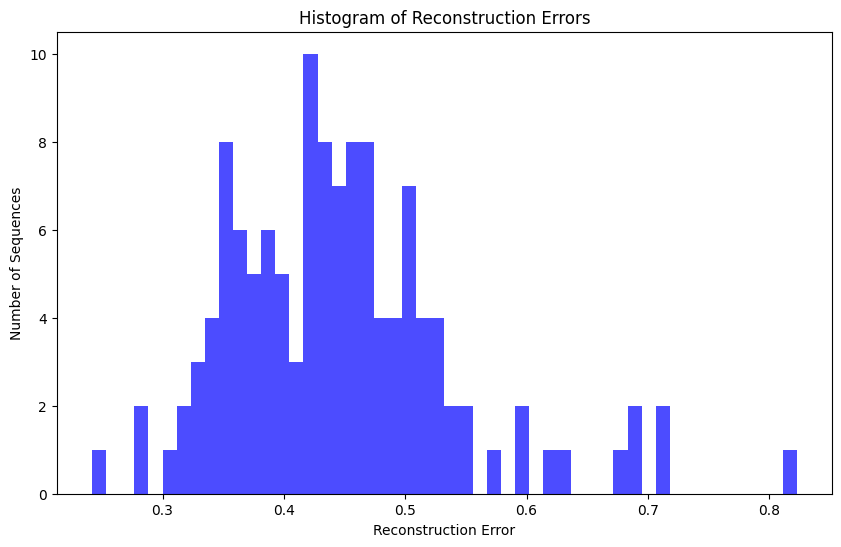


Evaluation Metrics:
              precision    recall  f1-score   support

      Normal       0.71      0.60      0.65        89
     Anomaly       0.28      0.39      0.33        36

    accuracy                           0.54       125
   macro avg       0.49      0.49      0.49       125
weighted avg       0.58      0.54      0.55       125



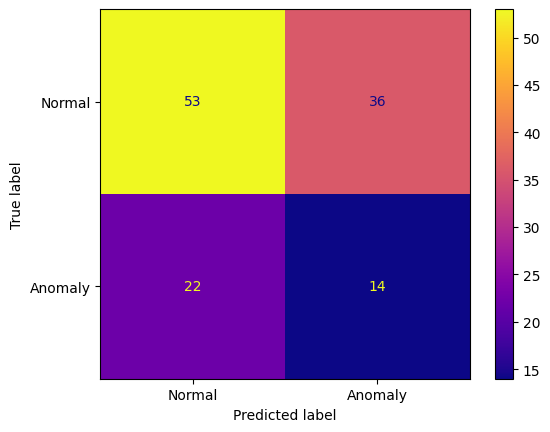

In [ ]:
# 1. Predict on test sequences
X_test_pred = model.predict(X_test_seq)

# 2. Calculate reconstruction errors
test_recon_errors = np.mean(np.mean(np.square(X_test_seq - X_test_pred), axis=1), axis=1)

# 3. Plot histogram of reconstruction errors
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(test_recon_errors, bins=50, color='blue', alpha=0.7)
plt.xlabel("Reconstruction Error")
plt.ylabel("Number of Sequences")
plt.title("Histogram of Reconstruction Errors")
plt.show()

# 4. Pick threshold (for example, 95th percentile)
threshold = np.percentile(test_recon_errors, 60)

# 5. Predict anomalies based on threshold
y_pred = (test_recon_errors > threshold).astype(int)

# 6. Evaluate performance
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("\nEvaluation Metrics:")
print(classification_report(y_test_seq, y_pred, target_names=["Normal", "Anomaly"]))

cm = confusion_matrix(y_test_seq, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap="plasma")




## Prep for data output file for use in dashboard

In [ ]:
THRESHOLD = 0.6
maintenance_needed = np.where(test_recon_errors > THRESHOLD, "Needs Attention", "Normal")

print(f"Predictions created: {len(maintenance_needed)}")

Predictions created: 125


In [ ]:
# Align: get last 125 rows after SEQ_LEN drop
df_test_results = df_sensors.iloc[-(125 + SEQ_LEN):-SEQ_LEN].copy()

print(f"Shape of df_test_results: {df_test_results.shape}")  # Should be (125, columns)

# Add Maintenance_Status
df_test_results['Maintenance_Status'] = maintenance_needed

Shape of df_test_results: (125, 21)


In [ ]:
columns_to_export = [
    'Timestamp', 'Machine_ID',
    'Temperature', 'Vibration', 'Pressure',
    'Temperature_delta', 'Vibration_delta', 'Pressure_delta',
    'Maintenance_Status'
]

df_final = df_test_results[columns_to_export]

df_final.to_csv("df_sensors_with_status.csv", index=False)

print("df_sensors_with_status created")


df_sensors_with_status created


In [ ]:
df_test_results['reconstruction_error'] = test_recon_errors
df_test_results['Maintenance_Status'] = maintenance_needed

# Export
df_final = df_test_results[[
    'Timestamp', 'Machine_ID',
    'Temperature', 'Vibration', 'Pressure',
    'Temperature_delta', 'Vibration_delta', 'Pressure_delta',
    'reconstruction_error', 'Maintenance_Status'
]]

df_final.to_csv("df_sensors_with_status_test_only.csv", index=False)

print("Final dashboard file created — matching test predictions!")


## LSTM Classification

drop features for split

In [ ]:
columns_to_drop = [
    'Timestamp', 'Machine_ID', 'Anomaly',
    'Maintenance_Status', 'Predicted_Maintenance_Status',
    'Maintenance_Status_4hr', 'Future_Anomaly'
]

df_features = df_sensors.drop(columns=columns_to_drop, errors='ignore')

# X features
X = df_features.iloc[:-4].copy()  # Now clean, no Future_Anomaly inside

# y labels
y = df_sensors['Future_Anomaly'].astype(int).values


scale data

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


create sequence

In [ ]:
SEQ_LEN = 7  # Look back 5 hours for each prediction

def create_supervised_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_supervised_sequences(X_scaled, y, SEQ_LEN)

print(f"X_seq shape: {X_seq.shape}, y_seq shape: {y_seq.shape}")


X_seq shape: (961, 7, 21), y_seq shape: (961,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")


Training samples: 768
Test samples: 193


In [ ]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(0.5231607629427792), 1: np.float64(11.294117647058824)}


In [ ]:
timesteps = X_train.shape[1]
n_features = X_train.shape[2]

model = Sequential([
    Bidirectional(LSTM(64, activation='tanh'), input_shape=(timesteps, n_features)),
    Dense(1, activation='sigmoid')  # Binary classification output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Precision', 'Recall'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        44,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,161 (172.50 KB)

 Trainable params: 44,161 (172.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1
)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - Precision: 0.0608 - Recall: 0.5943 - loss: 0.6499 - val_Precision: 0.0375 - val_Recall: 0.3333 - val_loss: 0.6675
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - Precision: 0.0764 - Recall: 0.8187 - loss: 0.5815 - val_Precision: 0.0435 - val_Recall: 0.4444 - val_loss: 0.6837
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Precision: 0.0783 - Recall: 0.8334 - loss: 0.5656 - val_Precision: 0.0465 - val_Recall: 0.4444 - val_loss: 0.6713
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - Precision: 0.0826 - Recall: 0.8261 - loss: 0.5403 - val_Precision: 0.0375 - val_Recall: 0.3333 - val_loss: 0.6484
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - Precision: 0.0854 - Recall: 0.8261 - loss: 0.5125 - val_Precision: 0.0435 - val_Recall: 0.3333 - val_loss: 0.6246
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - Precision: 0.0899 - Recall: 0.8261 - loss: 0.4847 - val_Precision: 0.0448 - val_Recall: 0.3333 - val_loss: 0.601

evaluate model

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.0337 - Recall: 0.0917 - loss: 0.4310         
Final Precision: 0.05
Final Recall: 0.11
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
              precision    recall  f1-score   support

      Normal       0.95      0.90      0.92       184
     Anomaly       0.05      0.11      0.07         9

    accuracy                           0.86       193
   macro avg       0.50      0.50      0.50       193
weighted avg       0.91      0.86      0.88       193



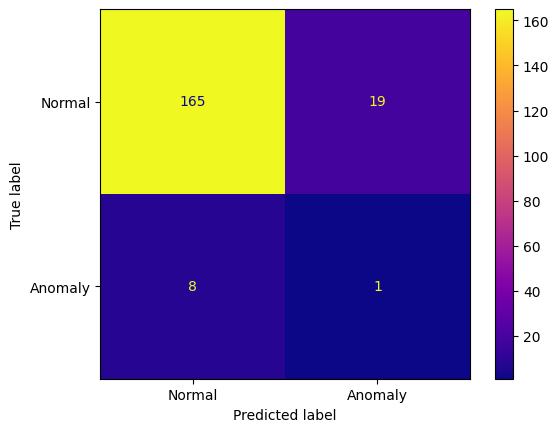

In [ ]:
# Evaluate
loss, precision, recall = model.evaluate(X_test, y_test)
print(f"Final Precision: {precision:.2f}")
print(f"Final Recall: {recall:.2f}")

# Predict
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Metrics
print(classification_report(y_test, y_pred, target_names=["Normal", "Anomaly"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap="plasma")


another loser!

## The LSTM Autoencoder is the only model that had aany level of performance and the clear winner!